In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from preprocess import extract
from preprocess.common import airports_top25, airports_top50
from regressionModels.tool_box import filtering_data_onehot, jointplot
from preprocess.airportvalues import airport_dict
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## Extract data
Extract all the data from the Eurocontrol dataset. Then filter out unrelevant data and outliers and save it in a correct way in a csv file. Data will be saved to a new folder called LRData but can be changed. The extracted data will be from the top 50 airports within Europe and a period between 2015 and 2019 by default.

In [ ]:
start = datetime(2017, 1, 1)
end = datetime(2019, 12, 31)

data = extract.extractData(start, end)

columns = [
    "ADEP",
    "ADES",
    "FiledOBT",
    "FiledAT",
    "ACType",
    "ACOperator",
    "ArrivalDelay",
    "DepartureDelay",
    "ADEPLat",
    "ADEPLong",
    "ADESLat",
    "ADESLong",
]

df_top20_flights = data.query("ADEP in @airports_top20 | ADES in @airports_top20")
df_top20_flights = extract.calculateDelays(df_top20_flights)
df_top20_flights = (
    df_top20_flights.loc[:, columns]
    .assign(month=lambda d: d.FiledAT.dt.month)
    .assign(weekday=lambda d: d.FiledAT.dt.weekday)
    .assign(filedATminutes=lambda d: d.FiledAT.dt.hour * 60 + d.FiledAT.dt.minute)
    .assign(filedOBTminutes=lambda d: d.FiledOBT.dt.hour * 60 + d.FiledOBT.dt.minute)
)

df_top20_flights.to_parquet("data/top50_airport_flights.parquet")

In [2]:
df_top20_flights = pd.read_parquet("data/top50_airport_flights.parquet")

## Encode data

This will encode the data. The capacity of the airport per 15 min will be calculated, the categorial features will be encoded and the data will be scaled. The functions returns all relevant features for the airport as X and the labels, the arrival delays as y.


In [3]:
X, y = filtering_data_onehot(df_top20_flights, airport="EGLL")


## Run RandomForest Regressor
Training and testing the RandomForestregressor. The hyperparamaters are the found optimal paramaters. If data for the requested airport was already saved in data uncomment first line. Otherwise run cell above and leave first line commented

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

forest = RandomForestRegressor(
    n_estimators=300,
    max_features="auto",
    max_depth=50,
    min_samples_split=10,
    min_samples_leaf=2,
    bootstrap=True,
    n_jobs=-1,
)

forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(mae, rmse, r2)


6.023890719299963 7.900642578601811 0.753747764381101


## Plot Results

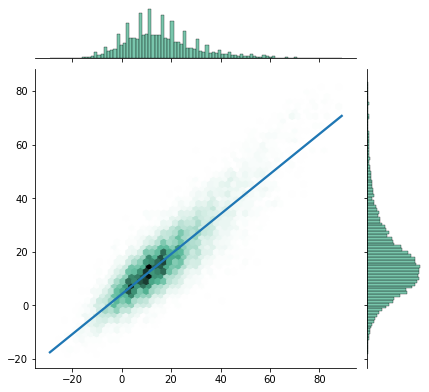

In [8]:
import seaborn as sns

g = sns.jointplot(
    x=y_test,
    y=y_pred,
    kind="hex",
    color="#4CB391",
)
sns.regplot(x=y_test, y=y_pred, scatter=False, ax=g.ax_joint)
g.fig.subplots_adjust(top=0.9)
plt.show()


## Run on multiple airports
Run The Random Forest on selected airports after eachother and save their errors. The errors of the top 50 airports in Europe are already saved to a dictionary called error_dict

In [20]:
errors = {}
results = []

for airport in airports_top25:
    print(f"Estimating delays for aiport: {airport}")

    X, y = filtering_data_onehot(df_top20_flights, airport=airport)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=True, random_state=42
    )
    forest = RandomForestRegressor(
        n_estimators=300,
        max_features="auto",
        max_depth=50,
        min_samples_split=10,
        min_samples_leaf=2,
        bootstrap=True,
        n_jobs=-1,
    )

    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    errors[airport] = dict(MAE=mae, RMSE=rmse, R2=r2)

    results.append(
        pd.DataFrame()
        .assign(delay=y_test)
        .assign(delay_est=y_pred)
        .assign(airport=airport)
    )


Estimating delays for aiport: EGLL
Estimating delays for aiport: LFPG
Estimating delays for aiport: EHAM
Estimating delays for aiport: EDDF
Estimating delays for aiport: LEMD
Estimating delays for aiport: LEBL
Estimating delays for aiport: LTFM
Estimating delays for aiport: UUEE
Estimating delays for aiport: EDDM
Estimating delays for aiport: EGKK
Estimating delays for aiport: LIRF
Estimating delays for aiport: EIDW
Estimating delays for aiport: LFPO
Estimating delays for aiport: LOWW
Estimating delays for aiport: LSZH
Estimating delays for aiport: LPPT
Estimating delays for aiport: EKCH
Estimating delays for aiport: LEPA
Estimating delays for aiport: EGCC
Estimating delays for aiport: LIMC
Estimating delays for aiport: ENGM
Estimating delays for aiport: UUDD
Estimating delays for aiport: EGSS
Estimating delays for aiport: EBBR
Estimating delays for aiport: ESSA


In [22]:

df_errors = pd.DataFrame.from_dict(errors, orient="index")
df_results = pd.concat(results, ignore_index=True)


In [25]:
# df_errors
df_results.to_parquet('data/top25_arrival_delay_rf_results.parquet')